In [4]:
# Mithil Patel 
# DSC 530 Week 7 Assignment
# 24th July, 2022

# Importing libraries
import thinkstats2
import numpy as np
from thinkstats2 import HypothesisTest
import first 

In [9]:
# Function for permutation to calculate the difference in mean 
class DiffMeansPermute(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

# class to test for Pearson's correlation 
class CorrelationPermute(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat
    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

# Class to find apparent difference in mean using chi-square statistic
class PregLengthTest(thinkstats2.HypothesisTest):
    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

In [10]:
# Function to calculate the p-value of four test using the subset of pregnancy length sample
def tests(df):
    firsts = df[df.birthord == 1]
    others = df[df.birthord != 1]
    
    dat_1 = firsts.prglngth.values, others.prglngth.values
    test_1 = DiffMeansPermute(dat_1)
    pval_1 = test_1.PValue(iters=1000)
    
    dat_2 = (firsts.totalwgt_lb.dropna().values, others.totalwgt_lb.dropna().values)
    test_2 = DiffMeansPermute(dat_2)
    pval_2 = test_2.PValue(iters=1000)
    
    test_3 = PregLengthTest(dat_1)
    pval_3 = test_3.PValue(iters=1000)
    
    dat4 = df.dropna(subset=['agepreg', 'totalwgt_lb'])
    dat_4 = dat4.agepreg.values, dat4.totalwgt_lb.values
    test_4 = CorrelationPermute(dat_4)
    pval_4 = test_4.PValue(iters=1000)
    
    return pval_1,pval_2,pval_3,pval_4

# Calling the test function and displaying the result with difference sample size
live, firsts, others = first.MakeFrames()
n = [200,400,700,1000,3000,6000,9000]
for i in range(len(n)):
    sample = thinkstats2.SampleRows(live, n[i])
    pval_1,pval_2,pval_3,pval_4 = tests(sample)
    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n[i], pval_1, pval_2, pval_3, pval_4))

200	0.47	0.41	0.01	0.26
400	0.14	0.03	0.03	0.00
700	0.83	0.15	0.00	0.25
1000	0.90	0.07	0.00	0.03
3000	0.99	0.00	0.00	0.00
6000	0.20	0.01	0.00	0.00
9000	0.19	0.00	0.00	0.00


The output is sporadic as the sample side increase, which is contrary to the expected positive values as the sample size increases. Additionally, there exist high positive values with smaller sample sizes such as n = 200 and 700.

Problem 10.1

In [6]:
# Importing dataframe
import brfss

# Cleaning the height and weight variable.
# Convert the weight variable to log scale
df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
height, log_weight = df.htm3, np.log10(df.wtkg2)
df.head()

,age,sex,wtyrago,finalwt,wtkg2,htm3
0,82.0,2,76.363636,185.870345,70.91,157.0
1,65.0,2,72.727273,126.603027,72.73,163.0
3,61.0,1,73.636364,517.926275,73.64,170.0
4,26.0,1,88.636364,1252.624630,88.64,185.0
5,42.0,1,118.181818,415.161314,109.09,183.0


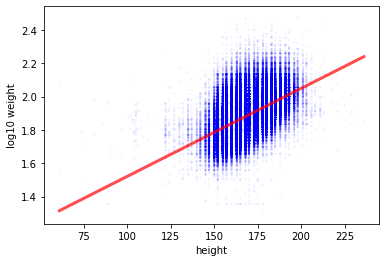

In [17]:
from thinkstats2 import MeanVar, Mean, Cov
import thinkplot

# Computing Linear least square fit for log(weight) vs height
def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)
    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx
    return inter, slope


def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

# Plotting the log(weight) vs height graph
inter, slope = LeastSquares(height, log_weight)
fx, fy = thinkstats2.FitLine(height, inter, slope)
thinkplot.Scatter(height, log_weight, alpha=0.05, s=5)
thinkplot.Plot(fx, fy, color='red')
thinkplot.Config(xlabel='height', ylabel='log10 weight', legend=True)

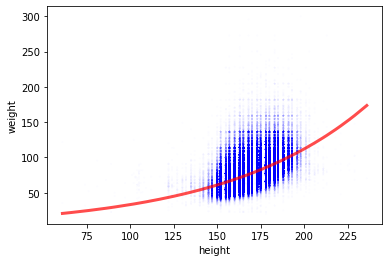

In [14]:
# Log-transforming height variable and then plotting it
thinkplot.Scatter(height, df.wtkg2, alpha=0.01, s=5)
thinkplot.Plot(fx, 10**fy, color='red')
thinkplot.Config(xlabel='height', ylabel='weight', legend=True)

In [19]:
# Calculating reduced root mean square error (RSME)
std_ys = thinkstats2.Std(log_weight)
res = thinkstats2.Residuals(height, log_weight, inter, slope)
std_res = thinkstats2.Std(res)
print(f"Reduced RMSE: {1 - std_res / std_ys}")

Reduced RMSE: 0.15308497658793563


The log(weight) vs height graph clearly shows a strong linear relationship. However, the y scale is in log10 which means that the relationship is exponential, and therefore one cannot predict one variable without knowing the other. However, the calculated reduced root mean square error (RSME) value of 15% highlight the high predictive power of our model and thus one can guess someone's weight by knowing their height. 

In [ ]:
from thinkstats2 import Mean, MeanVar, Var, Std

# Function for resampling rows
def ResampleRowsWeighted(df, column):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

# function to displays statistically summary(mean, standard error, and confidence interval) 
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    se = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    CI = cdf.ConfidenceInterval(90)
    print(f"Mean: {mean}\nStandard Error: {se}\nConfidence Interval:{CI}")
    return

# weighted resampling to estimate mean, standard error, and confidence interval
estimates_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimates_weighted)

In [12]:
# unweighted resampling to estimate mean, standard error, and confidence interval
estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimates_unweighted)

Mean: 168.95442109278684
Standard Error: 0.017268235444825714
Confidence Interval:(168.92125194526972, 168.97864498069887)
